# Predict Football Match Winners 🏆

## Table of Contents:
* [Introduction](#1)
* [Data Collection & Cleaning](#2)
    * [Data Download](#2.1)
    * [Scrape Data for Single Team & Single Season](#2.2)
    * [Scrape Data for Multiple Teams & Multiple Years](#2.3)
    * [Concatenate Data Frames](#2.4)
    * [Display Web-Scraped Data Frame](#2.5)
    * [Data Cleaning](#2.6)
    * [Remove Unnecessary Variables](#2.8)
    * [Create New Variables](#2.9)
* [Machine Learning](#3)
    * [Random Forest](#3.1)
    * [Why Random Forest?](#3.2)
    * [Training Algorithm](#3.3)
    * [Prediction & Accuracy](#3.4)
    * [Improving the Model](#3.5)
    * [Predictions Function](#3.6)
    * [Matching Results](#3.7)
* [Conclusion](#4)
    * [Further Development Suggestions](#4.1)

## Introduction ⚽ <a class="anchor" id="1"></a>

Welcome to this machine learning project with **Python**!

In this project, we will be analysing match data on **English Premier League (EPL)** matches to ultimately try and build a simple machine learning model that will predict football match results.

This project comprises two main sections:

- Web-scraping football match data
- Building machine learning model to predict match results

In the first section, we will be scraping web data on match statics from the [FB Ref](https://fbref.com/en/comps/9/Premier-League-Stats) website. This is an easy-to-use source for football stats including player, team, and league stats.

The second section involves building a machine learning model to try and predict the outcomes of football matches. The model that we will be employing is a **Random Forest**. After building an initial model, we will assess its predictive accuracy prior to trying to optimize its predictive power by enriching the data set with more predictors.

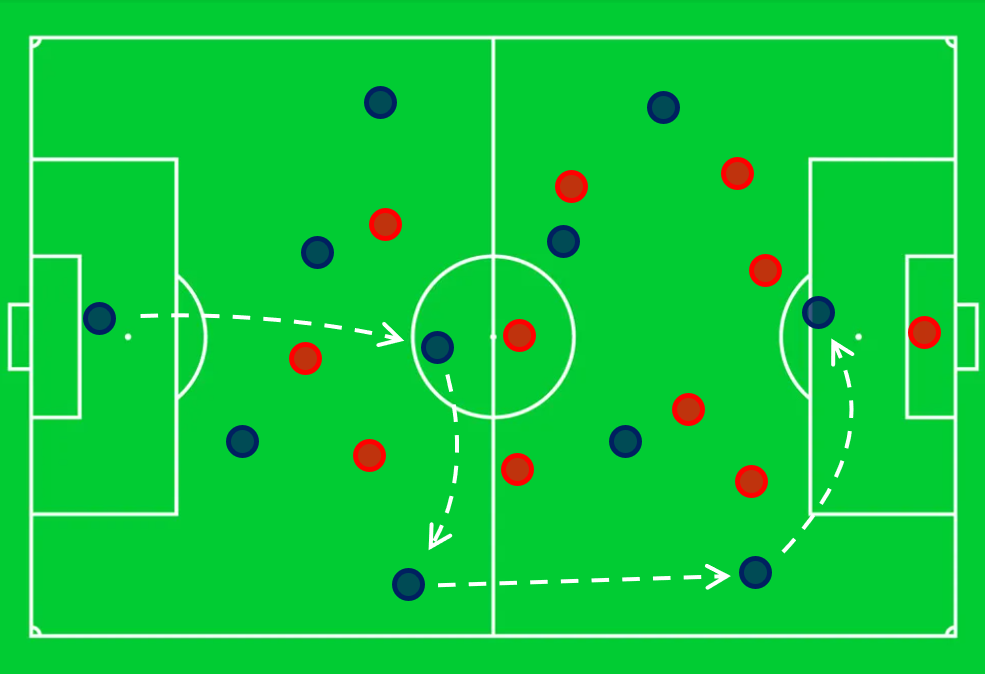

## Data Collection & Cleaning ⚽ <a class="anchor" id="2"></a>

We will be using data on English Premier League football matches. To get the data, we will need to scrape the match results from a website.

To begin, we will download the data using *Python*'s **requests** library. This will return *html* text data that we must then parse using the **BeautifulSoup** library enabling us to extract the relevant statistics tables. Finally, we will load everything into a **pandas** data frame in order to clean and prepare the data for building our machine learning model.

The data we are using will be scraped from the [FB Ref](https://fbref.com/en/comps/9/Premier-League-Stats) website.

### Data Download ⚽ <a class="anchor" id="2.1"></a>

In [1]:
import requests

In [2]:
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

We now need to use the **.get( )** method to make a request to the server and download *html* as a text file from the webpage.

In [3]:
data = requests.get(standings_url)

Using the command **data.text** would return to us a very long string of *html*. We will not perform this action, however, as the text is barely legible.

On the website, each squad (team) has a hyperlink to that will take you to its own page. These links are highlighted below in the **red box**. On these pages, there is a lot of information about games that has been collected, and we will be using to train out machine learning model.

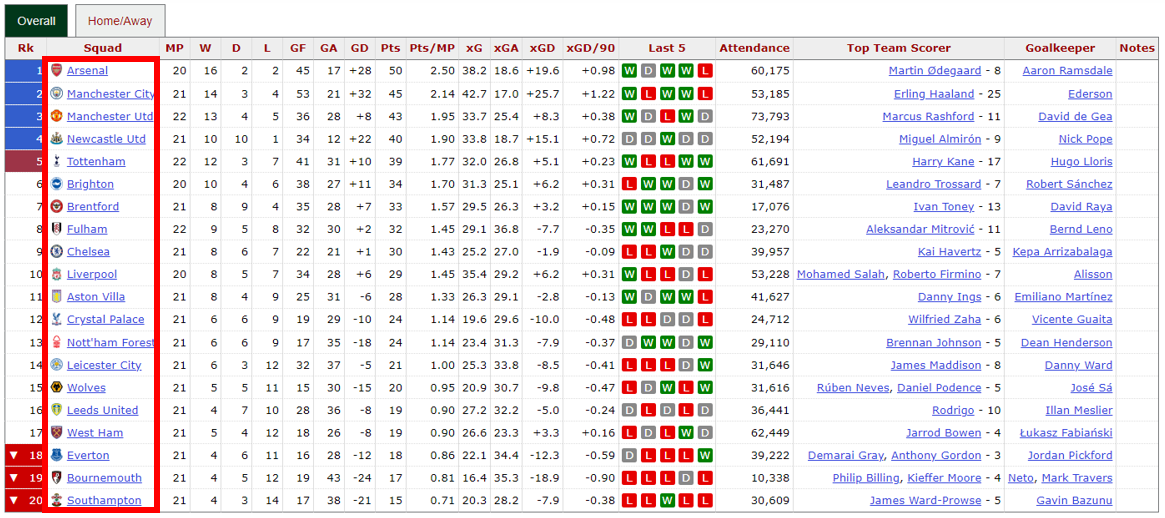

### Scrape Data for Single Team & Single Season ⚽ <a class="anchor" id="2.2"></a>

Before scraping match data for multiple teams and multiple years, we will run through the process for a single team and a single season, step-by-step, in order to build intuition.

On each team's page, there is a match log, and we want to be able to extract this data. In order to extract this data, we need the URLs for each team's page containing the match log. To do this, we will parse our *html* text file using the **BeautifulSoup** library.

After importing the **BeautifulSoup** library, we will:

1. Create a BeautifulSoup object and initialise this by feeding it our *html* text file
2. Use a CSS selector to give the object a table to select
3. Select the anchor tags with the links that we want from the table shown above
4. Retrieve **href** property of each link using a list comprehension
5. Filter links to get only squad / team links

In [4]:
from bs4 import BeautifulSoup

In [5]:
# (1) - Create and initialise the object
soup = BeautifulSoup(data.text)

# (2) - Use .select() to get first table with class stats_table
standings_table = soup.select('table.stats_table')[0]

# (3) - Find all <a> tags
links = standings_table.find_all('a')

# (4) - Get href for each link
links = [l.get("href") for l in links]

# (5) - Filter links
links = [l for l in links if '/squads/' in l]

The above code will return the links without the domain address. To turn our links into full URLs (or *absolute links*), we need to attach the domain name onto the front of each link using a *format string*.

In [6]:
team_urls = [f"https://fbref.com{l}" for l in links]

We will work with the first team's URL, i.e. the team currently leading in the Premier League.

In [7]:
data = requests.get(team_urls[0])

In the team's webpage, there is a table called **Scores & Fixtures** that contains information such as the date of the matches, the goals each team scored, the results, etc. 

In order to retrieve the data from this table, we will turn it into a **pandas** data frame using the **.html( )** method, as follows.

In [8]:
import pandas as pd

# Match scans for a specific string inside the table; this will return a list - take the first element
matches = pd.read_html(data.text, match="Scores & Fixtures")[0]

From this page, we also want to extract data on shooting statistics by following the **Shooting** tab link to another webpage.

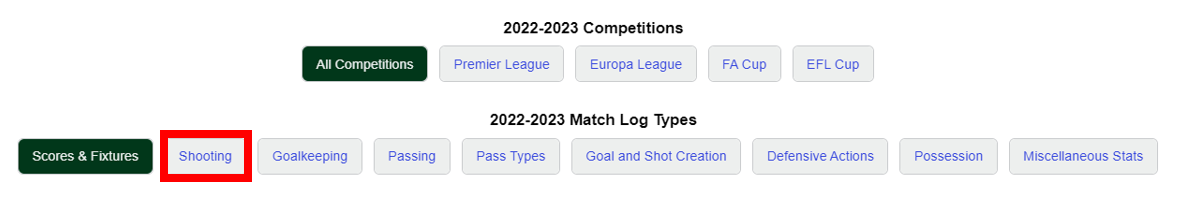

Let us find the URL of this **Shooting** page. After that, the process will be similar to what we have done before.

In [9]:
soup = BeautifulSoup(data.text)
links = soup.find_all('a')
links = [l.get("href") for l in links]
links = [l for l in links if l and 'all_comps/shooting/' in l]

In [10]:
data = requests.get(f"https://fbref.com{links[0]}")

In [11]:
shooting = pd.read_html(data.text, match="Shooting")[0]

In [12]:
# Display head of shooting data
shooting.head()

For Manchester City                                                     \
                 Date   Time              Comp                Round  Day   
0          2021-08-07  17:15  Community Shield  FA Community Shield  Sat   
1          2021-08-15  16:30    Premier League          Matchweek 1  Sun   
2          2021-08-21  15:00    Premier League          Matchweek 2  Sat   
3          2021-08-28  12:30    Premier League          Matchweek 3  Sat   
4          2021-09-11  15:00    Premier League          Matchweek 4  Sat   

                                         ... Standard               Expected  \
     Venue Result GF GA        Opponent  ...     Dist   FK PK PKatt       xG   
0  Neutral      L  0  1  Leicester City  ...      NaN  NaN  0     0      NaN   
1     Away      L  0  1       Tottenham  ...     16.9  1.0  0     0      1.9   
2     Home      W  5  0    Norwich City  ...     17.3  1.0  0     0      2.7   
3     Home      W  5  0         Arsenal  ...     14.3  0.0  0     0      3.8   
4     Away      W  1  0  Leicester City  ...     14.0  0.0  0     0      2.9   

                            Unnamed: 25_level_0  
  npxG npxG/Sh G-xG np:G-xG        Match Report  
0  NaN     NaN  NaN     NaN        Match Report  
1  1.9    0.11 -1.9    -1.9        Match Report  
2  2.7    0.17  1.3     1.3        Match Report  
3  3.8    0.15  1.2     1.2        Match Report  
4  2.9    0.12 -1.9    -1.9        Match Report  

[5 rows x 26 columns]

You may notice above that we appear to have a multi-level index. This will cause problems if we want to index based on - for example - **Round** or **GF**, so we need to remove this index level.

In [13]:
# Drop top index level
shooting.columns = shooting.columns.droplevel()

Finally, we must merge the two data frames together using the **.merge( )** method. We only want to merge the following columns, from the Shooting data frame:

- **Date**: Match date
- **Sh** : Shots
- **SoT** : Shots-on-target
- **Dist** : Average distance travelled by a shot
- **FK** : Free-kicks
- **PK** : Penalty kicks
- **PKatt** : Penalty kicks attempted

In [14]:
team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")

In [15]:
team_data.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Formation,Referee,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt
0,2021-08-07,17:15,Community Shield,FA Community Shield,Sat,Neutral,L,0,1,Leicester City,...,4-3-3,Paul Tierney,Match Report,NaN,12,3,NaN,NaN,0,0
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,4-3-3,Anthony Taylor,Match Report,NaN,18,4,16.9,1.0,0,0
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,4-3-3,Graham Scott,Match Report,NaN,16,4,17.3,1.0,0,0
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,4-3-3,Martin Atkinson,Match Report,NaN,25,10,14.3,0.0,0,0
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,4-3-3,Paul Tierney,Match Report,NaN,25,8,14.0,0.0,0,0


What we have done so far is to scrape the standings prior to downloading match and shooting statistics for a single team before combining this information into a single data frame. 

Next, we need to scale this method up and scrape data for multiple teams for multiple years.

### Scrape Data for Multiple Teams & Multiple Years ⚽ <a class="anchor" id="2.3"></a>

To scrape match data for multiple teams from multiple years, we will need to create a **for loop**.

First, we will create one list object containing the years we wish to pull data from, and also an empty list to store all of our data frames. Each data frame will contain the match logs for one team for one season.

In [16]:
years = list(range(2022, 2020, -1))
all_matches = []

standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

Now we will write a *for loop*. The below code may seem intimidating but it is predominantly what we have already done with a single team and a single season:

1. Loop through each year in the years list
2. Retrive URLs for each team's webpage
3. Loop through each team's webpage
4. Extract the 'Scores & Fixtures' table
5. Retrieve URLs for Shooting webpage
6. Extract Shooting table

Additional stages are

7. Wrap merge in try-block as some data is not always available and may cause merging issues
8. Filter on Premier League matches
9. Add additional columns to each data frame, to identify each data frame team and year
10. Add data frame to data frame list
11. Sleep for 1 second - this is important as some websites may block you if you make too many requests in a short period


In [17]:
import time

# (1) - Loop through the years
for year in years:
    
    # (2) - Retrieve the links for each team page
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    # Retrieve the links for previous season
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    # (3) - Loop through each team url
    for team_url in team_urls:
        
        # Extract team name from url
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        
        # Retrieve team URL
        data = requests.get(team_url)
        
        # (4) - Extract Scores and Fixtures table
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        
        # (5) - Retrieve URL for Shooting page
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        
        # (6) - Extract Shooting table 
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        
        # (7) - Wrap merge in a try statement
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
        except ValueError:
            continue
            
        # (8) - Filter for Premier League matches
        team_data = team_data[team_data["Comp"] == "Premier League"]
        
        # (9) - Add additional columns
        team_data["Season"] = year
        team_data["Team"] = team_name
        
        # (10) - Add data frame to all_matches list
        all_matches.append(team_data)
        
        # (11) - Sleep for 1 second
        time.sleep(1)

In [18]:
# Check how many data frames we have
len(all_matches)

39

### Concatenate Data Frames ⚽ <a class="anchor" id="2.4"></a>

We have ended up with 39 different data frames that we need to concatenate into one large one.

In [19]:
match_df = pd.concat(all_matches)

As a bit of house-keeping, we will also cast each column name to lower-case.

In [20]:
# Lower-case all of the columns
match_df.columns = [c.lower() for c in match_df.columns]

### Display Web-Scraped Data Frame ⚽ <a class="anchor" id="2.5"></a>

We finally have the data that we are going to use, stored as a data frame with 1389 observations and 27 variables.

In [21]:
match_df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,1,Tottenham,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,0,Norwich City,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,0,Arsenal,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,0,Leicester City,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0,0,Southampton,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2021-05-02,19:15,Premier League,Matchweek 34,Sun,Away,L,0,4,Tottenham,...,Match Report,NaN,8.0,1.0,17.4,0.0,0.0,0.0,2021,Sheffield United
39,2021-05-08,15:00,Premier League,Matchweek 35,Sat,Home,L,0,2,Crystal Palace,...,Match Report,NaN,7.0,0.0,11.4,1.0,0.0,0.0,2021,Sheffield United
40,2021-05-16,19:00,Premier League,Matchweek 36,Sun,Away,W,1,0,Everton,...,Match Report,NaN,10.0,3.0,17.0,0.0,0.0,0.0,2021,Sheffield United
41,2021-05-19,18:00,Premier League,Matchweek 37,Wed,Away,L,0,1,Newcastle Utd,...,Match Report,NaN,11.0,1.0,16.0,1.0,0.0,0.0,2021,Sheffield United


We want to save this to file, so we can continue to work on it without having to make unnecessary requests to the host website and risk getting blocked!

In [22]:
# Write to CSV file
match_df.to_csv("matches.csv")

If you are following along with the project but are struggling to get the web-scraping part to work, or may have gotten blocked by the web-server, **don't panic**! You can download the data that will be stored in my GitHub folder for this project. Click [here](https://github.com/th3RFC/portfolio/tree/dc3b22a14ec3baf6d4805c87aae046511fde6901/python/Capstone%20Projects/data). This will enable you to proceed with the next parts of the project.

### Data Cleaning ⚽ <a class="anchor" id="2.6"></a>

The next stage in this project is to clean the data. The code in this next section can be run independently of the web-scraping code above. It only assumes that you have downloaded the match.csv file from my GitHub folder.

To begin, we will read the data into our notebook as a **pandas** dataframe.

While we have already imported the *pandas* library in the web-scraping part of the project, we will re-import the module so that this code will work independently of code previously written.

In [23]:
import pandas as pd

In [24]:
matches = pd.read_csv("matches.csv", index_col=0)

In [25]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


We can use the **.shape( )** method to find the dimensions of our data frame. This will provide us with information on the number of observations and the number of variables per observation.

In [26]:
matches.shape

(1389, 27)

Thus, we have **1389** observations and **27** variables in our data frame, whereby each observation represents a single match. The variables include statistics on which team won or lost, goals for each team, shooting statistics and so on.

However, in the web-scraping part of the course, we looped over **2 seasons** of EPL matches, with **20 squads** per season, with each team playing **38 matches** per season. Do our numbers add up?

In [27]:
# 2 seasons * 20 squads * 38 matches
1389 - (2 * 20 * 38)

-131

It seems that our data frame is short by 131 observations (matches). Why?

We can use the **.value_counts( )** method to begin investigating this.

In [29]:
# Number of matches per team in EPL
matches["team"].value_counts().to_frame()

,team
Southampton,72
Brighton and Hove Albion,72
Manchester United,72
West Ham United,72
Newcastle United,72
Burnley,71
Leeds United,71
Crystal Palace,71
Manchester City,71
Wolverhampton Wanderers,71


We can see that most teams have played approximately 70-72 matches in the EPL. Given that this data was drawn part-way through a season, this is understandable. 

We can also see 7 teams with 38 or fewer matches played. Each season in the EPL, 3 teams are relegated and move down to the **Championship** league, while 3 teams end up being promoted from the Championship to the EPL. This would explain why 6 teams have fewer games played ... but we have 7. Why?

**Liverpool** having only 38 matches played looks a little bit suspect, as Liverpool is a strong team that tends to do well. It can be independently verified that Liverpool has not been relegated/ promoted in the last 2 EPL seasons. This would suggest that not all the matches for Liverpool have been pulled through. To investigate this further, we will filter on Liverpool.

In [30]:
matches[matches["team"] == "Liverpool"].sort_values("date")

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2020-09-12,17:30,Premier League,Matchweek 1,Sat,Home,W,4.0,3.0,Leeds United,...,Match Report,NaN,20.0,4.0,17.0,0.0,2.0,2.0,2021,Liverpool
2,2020-09-20,16:30,Premier League,Matchweek 2,Sun,Away,W,2.0,0.0,Chelsea,...,Match Report,NaN,17.0,5.0,17.7,1.0,0.0,0.0,2021,Liverpool
4,2020-09-28,20:00,Premier League,Matchweek 3,Mon,Home,W,3.0,1.0,Arsenal,...,Match Report,NaN,21.0,9.0,16.8,0.0,0.0,0.0,2021,Liverpool
6,2020-10-04,19:15,Premier League,Matchweek 4,Sun,Away,L,2.0,7.0,Aston Villa,...,Match Report,NaN,14.0,8.0,15.8,1.0,0.0,0.0,2021,Liverpool
7,2020-10-17,12:30,Premier League,Matchweek 5,Sat,Away,D,2.0,2.0,Everton,...,Match Report,NaN,22.0,8.0,15.0,1.0,0.0,0.0,2021,Liverpool
9,2020-10-24,20:00,Premier League,Matchweek 6,Sat,Home,W,2.0,1.0,Sheffield Utd,...,Match Report,NaN,17.0,5.0,18.2,1.0,0.0,0.0,2021,Liverpool
11,2020-10-31,17:30,Premier League,Matchweek 7,Sat,Home,W,2.0,1.0,West Ham,...,Match Report,NaN,8.0,2.0,18.6,1.0,1.0,1.0,2021,Liverpool
13,2020-11-08,16:30,Premier League,Matchweek 8,Sun,Away,D,1.0,1.0,Manchester City,...,Match Report,NaN,9.0,2.0,21.5,0.0,1.0,1.0,2021,Liverpool
14,2020-11-22,19:15,Premier League,Matchweek 9,Sun,Home,W,3.0,0.0,Leicester City,...,Match Report,NaN,24.0,12.0,11.9,0.0,0.0,0.0,2021,Liverpool
16,2020-11-28,12:30,Premier League,Matchweek 10,Sat,Away,D,1.0,1.0,Brighton,...,Match Report,NaN,6.0,2.0,20.9,0.0,0.0,0.0,2021,Liverpool


It would appear that we only have data for the **2020/21** season for Liverpool, and we are missing data for the **2021/22** season. The data should still be fine to work with, and at least we have an explanation for why some of the data is missing.

Next, we will look at the variable **round**. This gives the Matchweek that each game was played in. In an EPL season there are **38 Matchweeks**.

For most match weeks, we would typically expect the count to be **40** for each Matchweek, as we count one matchweek per team, and we have **20 teams** playing in each matchweek, across **2 seasons**, thus $20 \times 2=40$. However, we are missing Liverpool's 2021/22 season, so the maximum number we would expect is a count of 39.

Also, this data was scraped mid-season for the 2021/22 season, thus some of the later matchweeks will not have been played yet.

In [123]:
matches["round"].value_counts().to_frame()

,round
Matchweek 1,39
Matchweek 16,39
Matchweek 34,39
Matchweek 32,39
Matchweek 31,39
Matchweek 29,39
Matchweek 28,39
Matchweek 26,39
Matchweek 25,39
Matchweek 24,39


We can see that we have $39$ instances of each matchweek, as expected, but fewer counts for matchweeks $33$ onwards. This is because the last matchweek in the $2021/22$ season that had been played was the $32^{nd}$ matchweek. This is fine.

Now, we will check the data types of our variables using the **.dtypes** method. This is important as machine learning algorithms can only worth with numeric data.

If the column is stored as a different data type - such as *object* which typically denotes a string - then we have to find a way of converting these data types to numeric data in order to use them as predictors in our machine learning algorithm.

In [124]:
type = matches.dtypes.to_frame().rename(columns={0:" Data Type"})
type

,Data Type
date,object
time,object
comp,object
round,object
day,object
venue,object
result,object
gf,float64
ga,float64
opponent,object


### Remove Unnecessary Variables ⚽ <a class="anchor" id="2.8"></a>

Given that we have already filtered out matches that were not Premier League matches, the **comp** variable is now no longer relevant, so this can be removed. Also, we cannot easily convert **notes** to a numeric variable, so this can also be dropped.

In [125]:
del matches["comp"]

In [126]:
del matches["notes"]

### Create New Variables ⚽ <a class="anchor" id="2.9"></a>

The date variable appears to be stored as a string. We will over-write the existing column by converting it to a **datetime** data type using the **.to_datetime** method.

This will make it easier for us to use the date variable to compute predictors. For example, you could extract the month, or week day of the match.

In [127]:
matches["date"] = pd.to_datetime(matches["date"])

We also require a **target** variable to denote whether or not the team won a match.

In [128]:
matches["target"] = (matches["result"] == "W").astype("int")

The **venue_code** variable gives details on whether the team played at their home stadium, or at another team's stadium. This could be important, as the support of the home crowd can have a significant influence on the morale and performance of a team.

Currently, this variable is stored as a string, so we will convert it to a categorical data type using the **.astype( )** method. We will convert these categories to integers using the **.cat.codes( )** method. This will assign the value **0** for Away games and **1** for Home games.

In [129]:
matches["venue_code"] = matches["venue"].astype("category").cat.codes

We will repeat this by assigning integer values to the **opponent** variable. Evidently, the opponent will influence the outcome of the match.

In [130]:
matches["opp_code"] = matches["opponent"].astype("category").cat.codes

Do certain teams play better at certain times of day? To see if this may be the case, we will create a variable for the hour that the match is played.

In [131]:
# Use a regular expression to extract the hour
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")

We will create one final variable that will return the day of the week that the match is played on, assuming that some teams may play better on - for example - a Sunday versus a Saturday.

In [132]:
matches["day_code"] = matches["date"].dt.dayofweek

In [133]:
# Display data frame
matches

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,fk,pk,pkatt,season,team,target,venue_code,opp_code,hour,day_code
1,2021-08-15,16:30,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,1.9,...,1.0,0.0,0.0,2022,Manchester City,0,0,18,16,6
2,2021-08-21,15:00,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,2.7,...,1.0,0.0,0.0,2022,Manchester City,1,1,15,15,5
3,2021-08-28,12:30,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,3.8,...,0.0,0.0,0.0,2022,Manchester City,1,1,0,12,5
4,2021-09-11,15:00,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,2.9,...,0.0,0.0,0.0,2022,Manchester City,1,0,10,15,5
6,2021-09-18,15:00,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,1.1,...,1.0,0.0,0.0,2022,Manchester City,0,1,17,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2021-05-02,19:15,Matchweek 34,Sun,Away,L,0.0,4.0,Tottenham,0.5,...,0.0,0.0,0.0,2021,Sheffield United,0,0,18,19,6
39,2021-05-08,15:00,Matchweek 35,Sat,Home,L,0.0,2.0,Crystal Palace,0.7,...,1.0,0.0,0.0,2021,Sheffield United,0,1,6,15,5
40,2021-05-16,19:00,Matchweek 36,Sun,Away,W,1.0,0.0,Everton,1.6,...,0.0,0.0,0.0,2021,Sheffield United,1,0,7,19,6
41,2021-05-19,18:00,Matchweek 37,Wed,Away,L,0.0,1.0,Newcastle Utd,0.8,...,1.0,0.0,0.0,2021,Sheffield United,0,0,14,18,2


## Machine Learning ⚽ <a class="anchor" id="3"></a>

In this section, we will begin by training our machine learning model after giving a brief justification for the choice of algorithm: **Random Forest**.

After training our model, we will assess its predictive accuracy, and then seek to optimise this and improve the performance of our model.

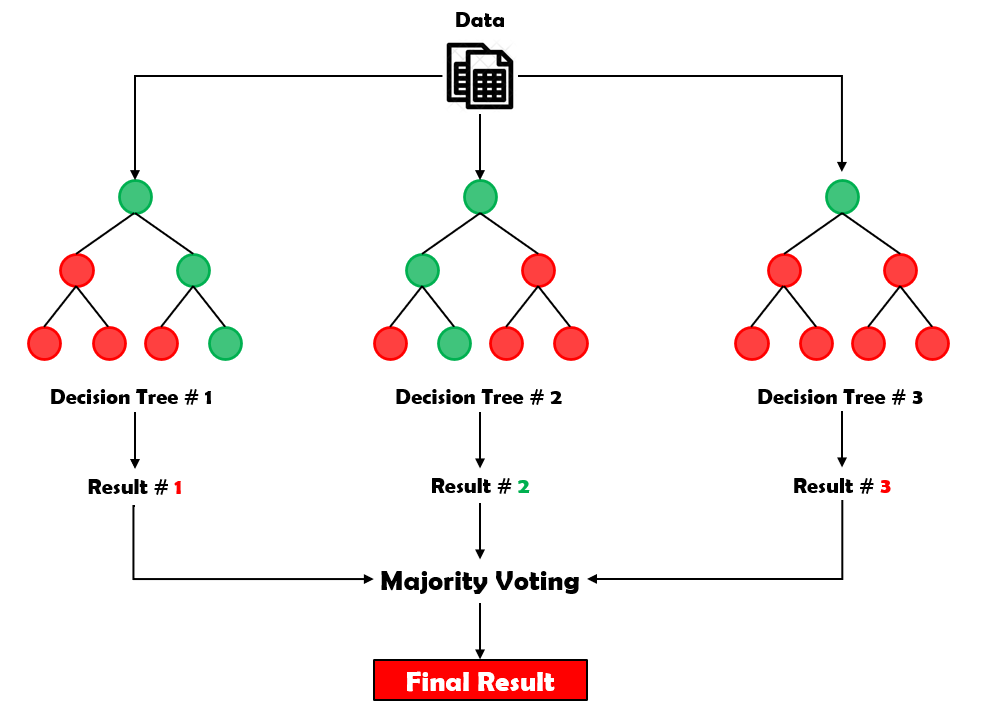

### Random Forest ⚽ <a class="anchor" id="3.1"></a>

Random forest is a commonly-used machine learning algorithm, which combines the output of multiple **decision trees** to reach a single result via *majority voting*. 

While its ease of use and flexibility have lent it to both classification and regression problems, we will be using it for a **classification** problem in this project, i.e. classifying whether or not a team will win a match of football.

### Why Random Forest? ⚽ <a class="anchor" id="3.2"></a>

The Random Forest model is useful as it can pick up *non-linearities* in the data that some other algorithms may struggle with. 

For example, we have created a column for **opponent** and assigned codes to it. A code of 15, for example, does not denote a team that is more or less challenging to play against that a team with code 14 or less; nor is a team with a code of 10 twice as difficult to play against as a team with code 5. They are just values to categorise different opponents numerically. A linear model would not be able to pick that up whereas a Random Forest can.

### Training Algorithm ⚽ <a class="anchor" id="3.3"></a>

First, we need to import the **RandomForestClassifier** from the **sklearn** library.

In [134]:
from sklearn.ensemble import RandomForestClassifier

Now, we want to create a Random Forest instance by initialising the Random Forest class. Below, we are going to enter in some hyper-paramters:

- **n_estimators** - How many Decision Trees we want in our Random Forest model
- **min_samples_split** - Number of samples we want to have in a leaf of a Decision Tree prior to splitting the node
- **random_state** - Set this to generate the same results each run

In [135]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

The next step is to create a **training** data set and a **testing** data set.

In [136]:
train = matches[matches["date"] < '2022-01-01']

In [137]:
test = matches[matches["date"] > '2022-01-01']

Create a list of the predictor columns that we created earlier.

In [138]:
predictors = ["venue_code", "opp_code", "hour", "day_code"]

Next, **fit** the model to the training data.

In [139]:
rf.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

### Prediction & Accuracy ⚽ <a class="anchor" id="3.4"></a>

So far, we have initialised a Random Forest model and trained the model using our test data set.

Now, we generate **predictions** using the test data set to assess the performance of the model that we have just trained.

In [140]:
preds = rf.predict(test[predictors])

To access the performance of our model, we will import the **accuracy_score** module.

Accuracy Score is a metric that returns a score for the **proportion of predictions made correctly**. For example, in this project, the number of 'Wins' and the number of 'Not Wins' that were correctly predicted are added together and divided by the total number of predictions made. If we made 6 correct predictions out of a total of 10 predictions, then our accuracy score would be: 

$$\frac{\text{# Correct Predictions}}{\text{# Total Predictions}} = \frac{6}{10}=0.6$$

In [141]:
from sklearn.metrics import accuracy_score

In [142]:
accuracy = accuracy_score(test["target"], preds)

In [143]:
accuracy

0.6123188405797102

A prediction **accuracy** of $\simeq 0.612$ suggests that our model correctly predicted the match result $61.2\%$ of the time.

We can go further, and drill down into this data to see if our model was better at - say - predicting wins versus predicting losses.

To do this, we will create a data frame that combines our actual values versus our predicted values. After this, we can create a **confusion matrix** (see below) using *cross-tabulation*.

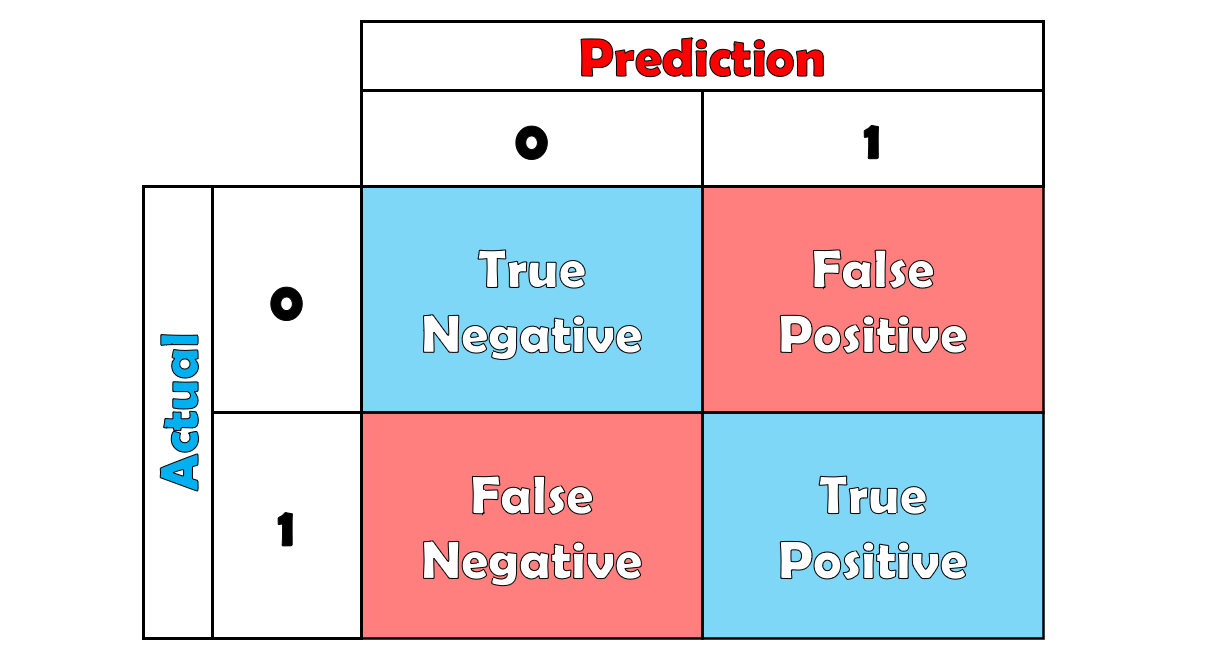

In [144]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=preds))

In [145]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,141,31
1,76,28


When we predicted a win, we were correct 28 times out of 59 (28 + 31) times, for example. This is approximately $47\%$ of the time, whereas we correctly predicted losses and draws approximately $65\%$ of the time.

It would appear that we are far **better at predicting losses and draws than wins**. Unfortunately, we are more concerned with out model predicting *wins* than losses and draws, so we will have to refine our model.

In light of this, we will revise our accuracy metric, and instead use the **precision score**.

The precision score tells us what proportion of the time we successfully predicted wins:

$$\text{Precision}=\frac{\text{True Positive}}{\text{True Positive + False Positive}}$$



In [146]:
from sklearn.metrics import precision_score

precision_score(test["target"], preds)

0.4745762711864407

This confirms our calculation above, that our precision is only around $47\%$. This isn't very good, so we are going to improve the model to see how this will affect its predictive ability.

### Improving the model ⚽ <a class="anchor" id="3.5"></a>

One way in which we can improve the model is to calculate how well a team had been performing going into a given match. Maybe if they were on a winning streak prior to a match, this may increase the likelihood they will win that match.

To create this variable, we will generate a **rolling average** of their match statistics.

To achieve this, we will create an object called *grouped_matches*. Essentially, this will create a separate data frame for each team in our data set.

In [147]:
grouped_matches = matches.groupby("team")

After creating this object, we can select a particular team using the **.get_group( )** method. We will use Manchester City as an example.

In [148]:
group = grouped_matches.get_group("Manchester City").sort_values("date")

This *group* object is a data frame containing all of the matches that Manchester City has played in.

We will create a rolling average function that will take in a group (team), a set of variables (match stats) from our existing data, and a set of new columns that the function will populate with the rolling averages for various match statistics.

We will want this function to:

1. Sort group in ascending order by date
2. Create a variable called rolling_stats that will take variables passed into the function and compute rolling averages
3. Assign rolling averages back to data frame as variables
4. Drop missing values

In [149]:
def rolling_averages(group, cols, new_cols):
    
    # (1) - Sort group by date
    group = group.sort_values("date")
    
    # (2) - Create rolling averages
    rolling_stats = group[cols].rolling(3, closed='left').mean() # closed = left takes preceding values
    
    # (3) - Create new data frame columns for rolling averages
    group[new_cols] = rolling_stats
    
    # (4) - Drop NA
    group = group.dropna(subset=new_cols)
    
    return group

To create our new variables for our rolling averages to populate, we will use string formatting to add a 'rolling'-suffix to the names of existing variables, for example $$\text{sh}\Rightarrow \text{sh_rolling}$$

In [150]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

rolling_averages(group, cols, new_cols)

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
5,2020-10-17,17:30,Matchweek 5,Sat,Home,W,1.0,0.0,Arsenal,1.5,...,17,5,2.000000,2.333333,17.333333,4.666667,18.900000,1.333333,0.333333,0.333333
7,2020-10-24,12:30,Matchweek 6,Sat,Away,D,1.0,1.0,West Ham,1.1,...,12,5,1.333333,2.000000,17.333333,3.666667,17.733333,0.666667,0.000000,0.000000
9,2020-10-31,12:30,Matchweek 7,Sat,Away,W,1.0,0.0,Sheffield Utd,1.5,...,12,5,1.000000,0.666667,16.666667,4.333333,18.233333,0.666667,0.000000,0.000000
11,2020-11-08,16:30,Matchweek 8,Sun,Home,D,1.0,1.0,Liverpool,1.6,...,16,6,1.000000,0.333333,14.333333,6.666667,18.466667,1.000000,0.000000,0.000000
12,2020-11-21,17:30,Matchweek 9,Sat,Away,L,0.0,2.0,Tottenham,1.3,...,17,5,1.000000,0.666667,12.000000,5.666667,19.366667,1.000000,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,2022-03-14,20:00,Matchweek 29,Mon,Away,D,0.0,0.0,Crystal Palace,2.3,...,20,0,2.333333,1.333333,19.000000,7.000000,15.366667,0.333333,0.333333,0.333333
44,2022-04-02,15:00,Matchweek 31,Sat,Away,W,2.0,0.0,Burnley,1.8,...,15,5,1.666667,0.333333,18.333333,7.333333,16.000000,0.333333,0.000000,0.000000
46,2022-04-10,16:30,Matchweek 32,Sun,Home,D,2.0,2.0,Liverpool,2.0,...,16,6,2.000000,0.333333,20.000000,6.666667,16.133333,0.333333,0.000000,0.000000
49,2022-04-20,20:00,Matchweek 30,Wed,Home,W,3.0,0.0,Brighton,1.2,...,20,2,1.333333,0.666667,15.666667,4.666667,16.700000,0.333333,0.000000,0.000000


Now we have shown this for Manchester City, we will create a **lambda function** and the **.apply( )** method to iterate this function over *all* of the teams in our data set. Very cool!

In [151]:
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))

In [152]:
matches_rolling

date   time         round  day venue result  \
team                                                                           
Arsenal                 6  2020-10-04  14:00   Matchweek 4  Sun  Home      W   
                        7  2020-10-17  17:30   Matchweek 5  Sat  Away      L   
                        9  2020-10-25  19:15   Matchweek 6  Sun  Home      L   
                        11 2020-11-01  16:30   Matchweek 7  Sun  Away      W   
                        13 2020-11-08  19:15   Matchweek 8  Sun  Home      L   
...                               ...    ...           ...  ...   ...    ...   
Wolverhampton Wanderers 32 2022-03-13  14:00  Matchweek 29  Sun  Away      W   
                        33 2022-03-18  20:00  Matchweek 30  Fri  Home      L   
                        34 2022-04-02  15:00  Matchweek 31  Sat  Home      W   
                        35 2022-04-08  20:00  Matchweek 32  Fri  Away      L   
                        36 2022-04-24  14:00  Matchweek 34  Sun  Away      L   

                             gf   ga         opponent   xg  ...  hour  \
team                                                        ...         
Arsenal                 6   2.0  1.0    Sheffield Utd  0.4  ...    14   
                        7   0.0  1.0  Manchester City  0.9  ...    17   
                        9   0.0  1.0   Leicester City  0.9  ...    19   
                        11  1.0  0.0   Manchester Utd  1.1  ...    16   
                        13  0.0  3.0      Aston Villa  1.5  ...    19   
...                         ...  ...              ...  ...  ...   ...   
Wolverhampton Wanderers 32  1.0  0.0          Everton  0.8  ...    14   
                        33  2.0  3.0     Leeds United  0.8  ...    20   
                        34  2.0  1.0      Aston Villa  1.2  ...    15   
                        35  0.0  1.0    Newcastle Utd  0.3  ...    20   
                        36  0.0  1.0          Burnley  0.7  ...    14   

                            day_code  gf_rolling ga_rolling sh_rolling  \
team                                                                     
Arsenal                 6          6    2.000000   1.333333   7.666667   
                        7          5    1.666667   1.666667   5.333333   
                        9          6    1.000000   1.666667   7.000000   
                        11         6    0.666667   1.000000   9.666667   
                        13         6    0.333333   0.666667   9.666667   
...                              ...         ...        ...        ...   
Wolverhampton Wanderers 32         6    1.333333   1.000000  12.333333   
                        33         4    1.666667   0.666667  12.333333   
                        34         5    2.333333   1.000000  13.000000   
                        35         4    1.666667   1.333333  13.000000   
                        36         6    1.333333   1.666667  10.000000   

                           sot_rolling dist_rolling  fk_rolling  pk_rolling  \
team                                                                          
Arsenal                 6     3.666667    14.733333    0.666667    0.000000   
                        7     3.666667    15.766667    0.000000    0.000000   
                        9     3.666667    16.733333    0.666667    0.000000   
                        11    4.000000    16.033333    1.000000    0.000000   
                        13    2.666667    18.033333    1.000000    0.333333   
...                                ...          ...         ...         ...   
Wolverhampton Wanderers 32    3.666667    19.300000    0.000000    0.000000   
                        33    4.333333    19.600000    0.000000    0.000000   
                        34    5.333333    19.833333    0.000000    0.000000   
                        35    5.000000    18.533333    0.000000    0.000000   
                        36    4.666667    17.633333    0.000000    0.000000   

                            pkatt_rolling  
team   

Notice again that we appear to have generated an additional index level. Let's drop this before proceeding.

In [153]:
matches_rolling = matches_rolling.droplevel('team')

In [154]:
# Display data frame
matches_rolling

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
6,2020-10-04,14:00,Matchweek 4,Sun,Home,W,2.0,1.0,Sheffield Utd,0.4,...,14,6,2.000000,1.333333,7.666667,3.666667,14.733333,0.666667,0.000000,0.000000
7,2020-10-17,17:30,Matchweek 5,Sat,Away,L,0.0,1.0,Manchester City,0.9,...,17,5,1.666667,1.666667,5.333333,3.666667,15.766667,0.000000,0.000000,0.000000
9,2020-10-25,19:15,Matchweek 6,Sun,Home,L,0.0,1.0,Leicester City,0.9,...,19,6,1.000000,1.666667,7.000000,3.666667,16.733333,0.666667,0.000000,0.000000
11,2020-11-01,16:30,Matchweek 7,Sun,Away,W,1.0,0.0,Manchester Utd,1.1,...,16,6,0.666667,1.000000,9.666667,4.000000,16.033333,1.000000,0.000000,0.000000
13,2020-11-08,19:15,Matchweek 8,Sun,Home,L,0.0,3.0,Aston Villa,1.5,...,19,6,0.333333,0.666667,9.666667,2.666667,18.033333,1.000000,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,2022-03-13,14:00,Matchweek 29,Sun,Away,W,1.0,0.0,Everton,0.8,...,14,6,1.333333,1.000000,12.333333,3.666667,19.300000,0.000000,0.000000,0.000000
33,2022-03-18,20:00,Matchweek 30,Fri,Home,L,2.0,3.0,Leeds United,0.8,...,20,4,1.666667,0.666667,12.333333,4.333333,19.600000,0.000000,0.000000,0.000000
34,2022-04-02,15:00,Matchweek 31,Sat,Home,W,2.0,1.0,Aston Villa,1.2,...,15,5,2.333333,1.000000,13.000000,5.333333,19.833333,0.000000,0.000000,0.000000
35,2022-04-08,20:00,Matchweek 32,Fri,Away,L,0.0,1.0,Newcastle Utd,0.3,...,20,4,1.666667,1.333333,13.000000,5.000000,18.533333,0.000000,0.000000,0.000000


It may be noticed that many of our index values are being repeated, so we will reset out index. This is important as we want unique values for our index.

In [155]:
matches_rolling.index = range(matches_rolling.shape[0])

### Predictions Function ⚽ <a class="anchor" id="3.6"></a>

In this sub-section we will create a predictions function that we can use to make predictions without having to repeat significant chunks of code for each model we wish to test. This function will:

1. Split data into training- and test-sets
2. Fit the model to training data
3. Make predictions using testing data
4. Combine actuals and predictions together
5. Calculate precision

In [156]:
def make_predictions(data, predictors):
    
    # (1) - Split data
    train = data[data["date"] < '2022-01-01']
    test = data[data["date"] > '2022-01-01']
    
    # (2) - Fit model
    rf.fit(train[predictors], train["target"])
    
    # (3) - Make predictions
    preds = rf.predict(test[predictors])
    
    # (4) - Combine actuals and predictions
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    
    # (5) - Calculate precision
    error = precision_score(test["target"], preds)
    
    return combined, error

We can now call this function and pass in our original predictors *and* the rolling averages we have just generated.

In [157]:
combined, precision = make_predictions(matches_rolling, predictors + new_cols)

In [158]:
precision

0.625

At $62.5\%$, we have clearly improved our precision markedly.

We can also see how the predicted result for each match compared with its actual result by running the *combined* command.

In [159]:
combined

,actual,predicted
55,0,0
56,1,0
57,1,0
58,1,1
59,1,1
...,...,...
1312,1,0
1313,0,0
1314,1,0
1315,0,0


However, this does not really give us much information about those matches, such as when the match happened, which teams were playing, etc. We can enrich our combined data frame using the **.merge( )** method to add in match details, as shown below.

In [160]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)

In [161]:
# Display first 10 matches
combined.head(10)

,actual,predicted,date,team,opponent,result
55,0,0,2022-01-23,Arsenal,Burnley,D
56,1,0,2022-02-10,Arsenal,Wolves,W
57,1,0,2022-02-19,Arsenal,Brentford,W
58,1,1,2022-02-24,Arsenal,Wolves,W
59,1,1,2022-03-06,Arsenal,Watford,W
60,1,1,2022-03-13,Arsenal,Leicester City,W
61,0,1,2022-03-16,Arsenal,Liverpool,L
62,1,0,2022-03-19,Arsenal,Aston Villa,W
63,0,0,2022-04-04,Arsenal,Crystal Palace,L
64,0,0,2022-04-09,Arsenal,Brighton,L


### Matching Results ⚽ <a class="anchor" id="3.7"></a>

In our analysis, we made predictions for each match **twice**. Once from the perspective of the Home team and one from the perspective of the Away team. **Did our model predict the same overall result for that match for both perspectives?** 

For example, if Arsenal is playing at Home against Everton in a given season, and the prediction is a win for Arsenal, then will the model also predict a 'Loss' for Everton playing Away against Arsenal in the same season?

To check this, we can combine our data together. First, we need to ensure that the *team* name and the *opponent* name are the same in our data set, as sometimes they are not. For instance, we have **Wolverhampton Wanderers** in the *team* column and **Wolves** in the *opponent* column for the same team.

To make sure that the names are consistent across both columns, we will create a *dictionary* and use the **.map( )** method with that dictionary. However, we must first create a **child class** that *inherents* from the dictionary class. For a good explanation of class inheritance, click [here]("https://www.w3schools.com/python/python_inheritance.asp").

We need to do this because the .map( ) method does not handle any **missing keys**. So, if the dictionary being mapped to a column is - for example - missing a team name, the .map( ) method will simply remove that team's observation from the data. For instance, if we create a mapping dictionary that has a key 'Wolverhampton Wanderers' with a value 'Wolves', then passing 'Wolverhampton Wanderers' will return the value 'Wolves'. However, if we pass in 'Arsenal' but there is no key for this team, then the observation will be removed from the data. 

Instead, we want the mapping function to simply return the team name that it is passed if no key exists for that team. This is illustrated below.

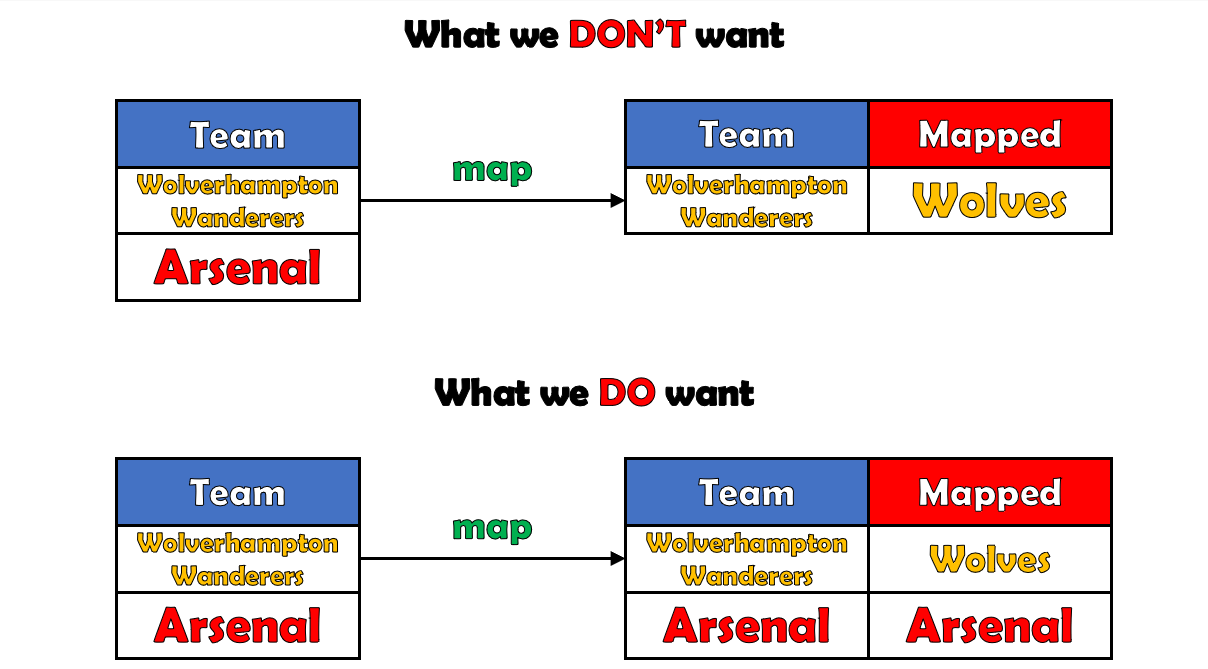

We begin by creating a child class called **MissingDict**. We pass *dict* into the argument, so it will inherit from the *dict class*. This class will leverage a Python **hook** called *missing*. A hook can be used to tap into a module and react when something happens; in this case, when there is a missing key.  

After this, we want to create a mapping dictionary before finally passing this dictionary as an argument to our **MissingDict** class to create an instance of it, *mapping*. When we do this, we will use type two astericks prior to *map_values*. We do this because you cannot directly send a dictionary as a parameter to a function accepting kwargs (key word arguments). The **dictionary must be unpacked** so that the function may make use of its elements. The two astericks accomplish this.

In [162]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Brighton and Hove Albion": "Brighton", 
              "Manchester United": "Manchester Utd", 
              "Newcastle United": "Newcastle Utd", 
              "Tottenham Hotspur": "Tottenham", 
              "West Ham United": "West Ham", 
              "Wolverhampton Wanderers": "Wolves"} 
mapping = MissingDict(**map_values)

We can now use this in our **.map( )** method.

In [163]:
combined["new_team"] = combined["team"].map(mapping)

#Display data frame
combined

,actual,predicted,date,team,opponent,result,new_team
55,0,0,2022-01-23,Arsenal,Burnley,D,Arsenal
56,1,0,2022-02-10,Arsenal,Wolves,W,Arsenal
57,1,0,2022-02-19,Arsenal,Brentford,W,Arsenal
58,1,1,2022-02-24,Arsenal,Wolves,W,Arsenal
59,1,1,2022-03-06,Arsenal,Watford,W,Arsenal
...,...,...,...,...,...,...,...
1312,1,0,2022-03-13,Wolverhampton Wanderers,Everton,W,Wolves
1313,0,0,2022-03-18,Wolverhampton Wanderers,Leeds United,L,Wolves
1314,1,0,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,Wolves
1315,0,0,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,Wolves


As you can see above, we now have a **new_team** variable that contains the same teams as in the **team** column, but with the same naming convention as in the **opponent** column.

We can now merge this data frame *with itself*, by merging on the *date* and *new_team* variables for one data frame, but using the *date* and *opponent* in the other data frame. The purpose of this is to create a data frame with **two predicted** values for each observation, one prediction made from the Home team's perspective, and the other from their opponent's perspective.

This process is illustrated below. **prediction_x** is the original match prediction made for that team, whereas **prediction_y** is the prediction from the perspective of the opponent.

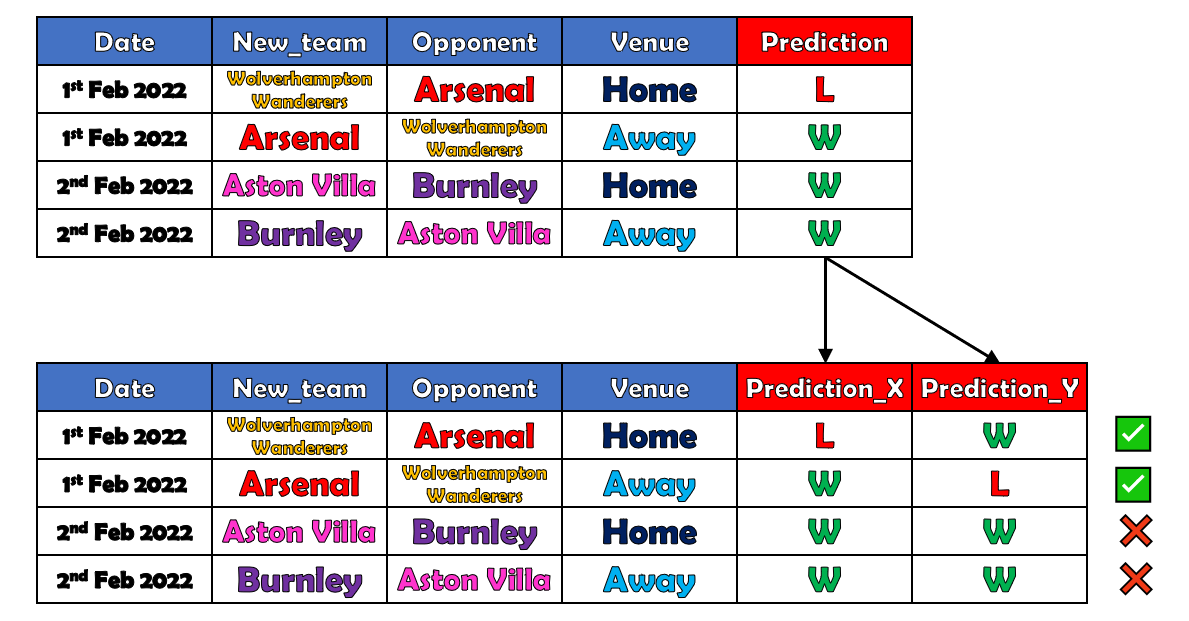

In the first row in the top table in our illustration, Wolverhampton Wanderers are playing Arsenal at Home on the $1^{st}$ February $2022$. The predicted result for Wolverhampton Wanderers is a loss (L). The second row is the *same* match but from the perspective of Arsenal, who are playing Wolverhampton Wanderers Away on the $1^{st}$ February $2022$ and predicted to win (W). The third and fourth row relate to a single game between Aston Villa and Burnley.

The second table is post-merge. In the first row, we again have Wolverhampton Wanderers playing Arsenal at Home on the $1^{st}$ February $2022$. The **prediction_x** returns the original predicted match result for this team, a loss (L). **prediction_y** returns the predicted result from Arsenal's perspective, which is a win (W). This makes sense, as if one team loses, the other team must - by definition - win: these two columns should have *different values*.

For the Aston Villa and Burnley match, however, *prediction_x* and *prediction_y* are the same for both teams meaning that our algorithm predicted that *both* teams won the match. This is not possible in reality, so this would count against our model.

In [164]:
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])

In [165]:
merged

,actual_x,predicted_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,team_y,opponent_y,result_y,new_team_y
0,0,0,2022-01-23,Arsenal,Burnley,D,Arsenal,0,0,Burnley,Arsenal,D,Burnley
1,1,0,2022-02-10,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
2,1,0,2022-02-19,Arsenal,Brentford,W,Arsenal,0,0,Brentford,Arsenal,L,Brentford
3,1,1,2022-02-24,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
4,1,1,2022-03-06,Arsenal,Watford,W,Arsenal,0,0,Watford,Arsenal,L,Watford
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,1,0,2022-03-13,Wolverhampton Wanderers,Everton,W,Wolves,0,0,Everton,Wolves,L,Everton
258,0,0,2022-03-18,Wolverhampton Wanderers,Leeds United,L,Wolves,1,0,Leeds United,Wolves,W,Leeds United
259,1,0,2022-04-02,Wolverhampton Wanderers,Aston Villa,W,Wolves,0,0,Aston Villa,Wolves,L,Aston Villa
260,0,0,2022-04-08,Wolverhampton Wanderers,Newcastle Utd,L,Wolves,1,0,Newcastle United,Wolves,W,Newcastle Utd


We can now look at just the rows where one team was predicted to win and where the other team was predicted to lose.

In [166]:
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] ==0)]["actual_x"].value_counts()

1    27
0    13
Name: actual_x, dtype: int64

This result suggests that our when our algorithm predicted that one team would win, it correctly predicted that the other team would lose $27$ out of $40$ times, which is $67.5\%$. This is not too terrible, but not great either.

## Conclusion ⚽ <a class="anchor" id="4"></a>

In this project, we web-scraped football data for English Premier League matches across two seasons. After cleaning our data, we enriched it by creating new predictors.

We used a Random Forest algorithm courtesy of the *sklearn* library. After training our model, we assessed its performance. Initially, this was not very strong with a precision of only $47\%$.

We further enriched our data by creating rolling averages for each team's performance in the prior three games. This resulted in a considerable improvement to our model, with a new precision score of $62.5\%$.

Finally, we checked the extent to which our model made consistent predictions. We found that when our model predicted that a team would win a match, it also predicted that their opponent would lose $67.5\%$ of the time.

### Further Development Suggestions ⚽ <a class="anchor" id="4.1"></a>

There is a variety of ways in which this project could be improved upon that will now be briefly discussed. 

One way would be to change the values of our Random Forest **hyper-parameters**, for instance, by altering the number of Decision Trees used in our forest. Typically, the more trees used, the greater the predictive power.

It tends to be a good idea to use **cross-validation** on your data in order to select the best model. Also, other classifier models that can handle non-linear data could have been employed. 

Finally, we could have **used more variables** as predictors. There were other tabs on each team's page that contained more match stats pertaining to goalkeeping, passing, and possession statistics.